In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt

# 載入MNIST數據函數
def load_images(filename):
    with open(filename, 'rb') as f:
        _, num, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape((num, rows * cols))
        return data.astype(np.float32) / 255.0

def load_labels(filename):
    with open(filename, 'rb') as f:
        _, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels[:num]


In [2]:
 # TODO: Complete all the functions, you may change the structures
# ========= 2. Utils ==========
# 工具函數
def shuffle_numpy(X, y):
    idx = np.random.permutation(len(X))
    return X[idx], y[idx]

def split_train_val(X, y, val_ratio=0.2):
    val_size = int(len(X) * val_ratio)
    return X[val_size:], y[val_size:], X[:val_size], y[:val_size]

def one_hot(y, num_classes):
    return np.eye(num_classes)[y]

def accuracy(Y_pred, Y_true):
    return np.mean(np.argmax(Y_pred, axis=1) == np.argmax(Y_true, axis=1))

# 神經網路模型
class MLP:
    def __init__(self, input_dim, hidden_dim, output_dim, weight_decay=0.0):
        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.01
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, output_dim) * 0.01
        self.b2 = np.zeros((1, output_dim))
        self.lambda_ = weight_decay

    def relu(self, x):
        return np.maximum(0, x)

    def relu_deriv(self, x):
        return (x > 0).astype(float)

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)

    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = self.softmax(self.z2)
        return self.a2

    def compute_loss(self, Y_pred, Y_true):
        loss = -np.sum(Y_true * np.log(Y_pred + 1e-8)) / Y_true.shape[0]
        l2_penalty = (self.lambda_ / 2) * (np.sum(self.W1 ** 2) + np.sum(self.W2 ** 2))
        return loss + l2_penalty

    def backward(self, X, Y_true, Y_pred, lr=0.1):
        m = Y_true.shape[0]
        dz2 = (Y_pred - Y_true) / m
        dW2 = self.a1.T @ dz2 + self.lambda_ * self.W2
        db2 = np.sum(dz2, axis=0, keepdims=True)
        da1 = dz2 @ self.W2.T
        dz1 = da1 * self.relu_deriv(self.z1)
        dW1 = X.T @ dz1 + self.lambda_ * self.W1
        db1 = np.sum(dz1, axis=0, keepdims=True)

        self.W2 -= lr * dW2
        self.b2 -= lr * db2
        self.W1 -= lr * dW1
        self.b1 -= lr * db1


In [3]:
# 訓練函數
def train(model, X_train, y_train, X_val, y_val, lr=0.1, epochs=50, use_early_stopping=False, patience=5):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    best_val_loss, patience_count = np.inf, 0

    for epoch in range(epochs):

        Y_pred_train = model.forward(X_train)
        loss = model.compute_loss(Y_pred_train, y_train)
        model.backward(X_train, y_train, Y_pred_train, lr)

        Y_pred_val = model.forward(X_val)
        val_loss = model.compute_loss(Y_pred_val, y_val)

        train_losses.append(loss)
        val_losses.append(val_loss)
        train_accs.append(accuracy(Y_pred_train, y_train))
        val_accs.append(accuracy(Y_pred_val, y_val))

        if use_early_stopping:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_count = 0
            else:
                patience_count += 1
                if patience_count >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

    return train_losses, val_losses, train_accs, val_accs




In [4]:
# ========= 5. Plotting ==========
import matplotlib.pyplot as plt

def plot_curves(train_losses, val_losses, train_accs, val_accs, title):
    plt.figure(figsize=(12, 5))

    # Loss 曲線
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss", linewidth=2)
    plt.plot(val_losses, label="Val Loss", linewidth=2)
    plt.title("Loss Curve - " + title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Accuracy 曲線
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Acc", linewidth=2)
    plt.plot(val_accs, label="Val Acc", linewidth=2)
    plt.title("Accuracy Curve - " + title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


Training with Early Stopping...


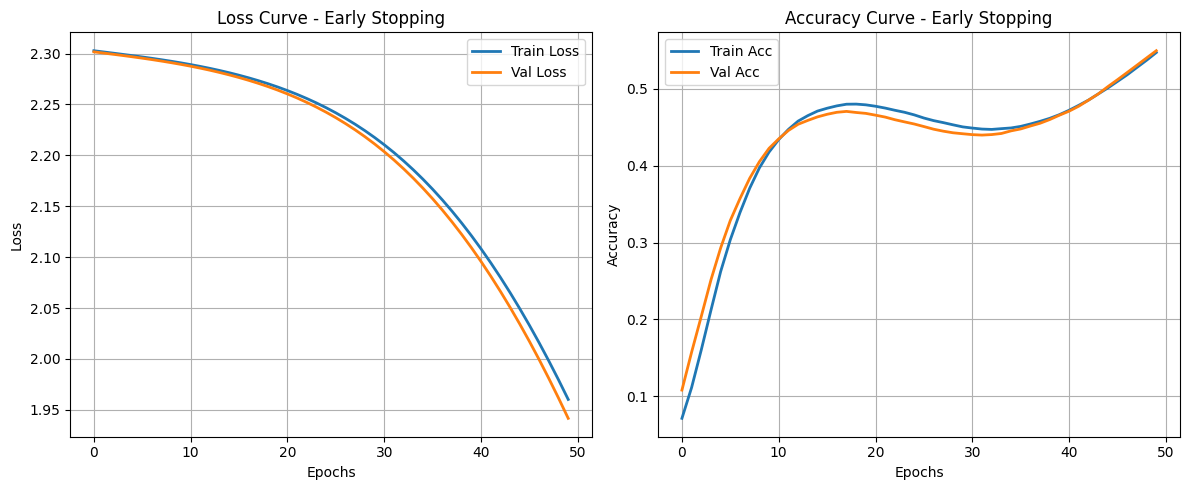


Training with Weight Decay (λ = 0.0)...


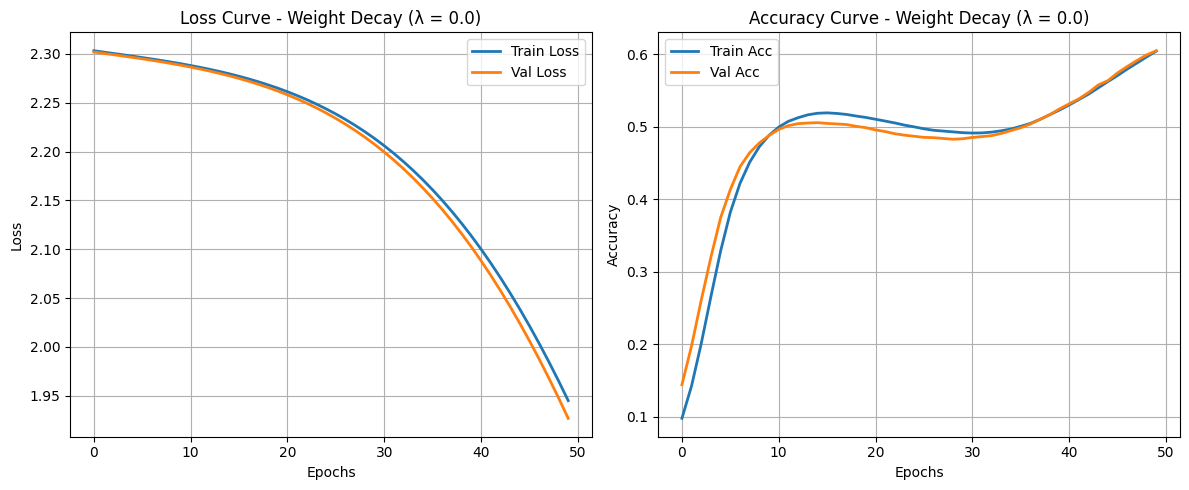


Training with Weight Decay (λ = 0.001)...


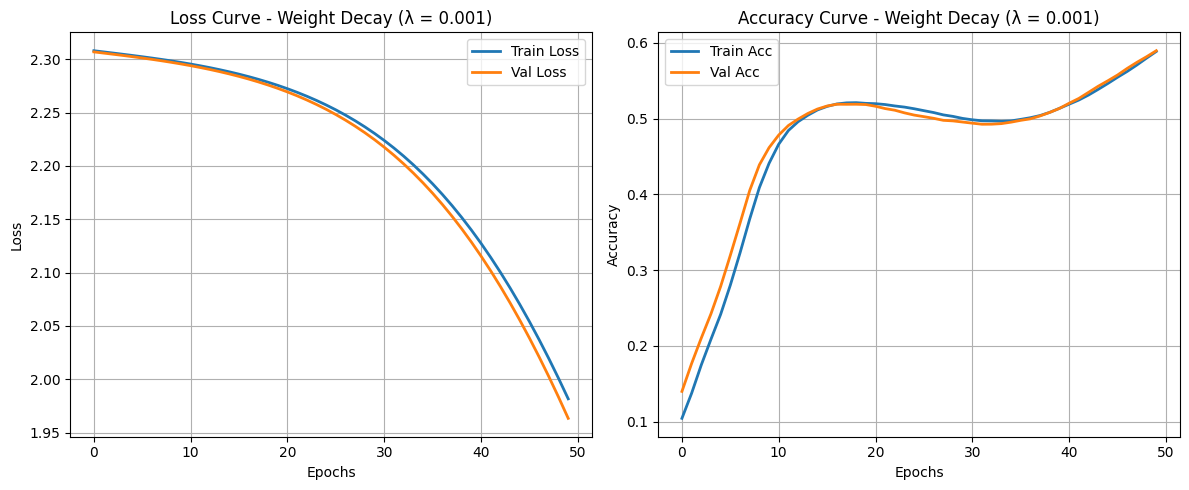


Training with Weight Decay (λ = 0.01)...


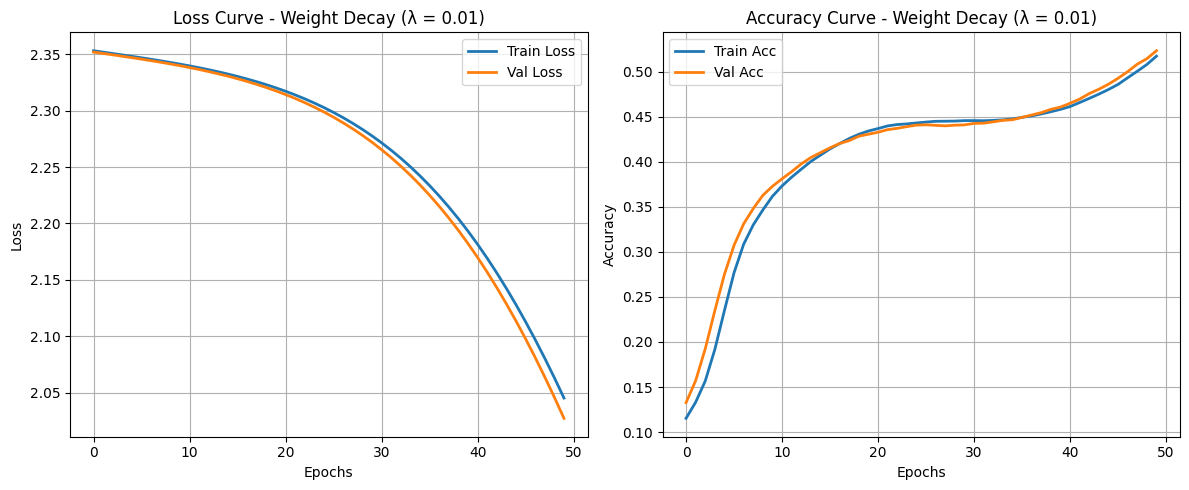

In [6]:
# ========= 6. Main ==========
if __name__ == "__main__":
    # 載入數據
    X = load_images("train-images.idx3-ubyte_____")
    y = load_labels("train-labels.idx1-ubyte_____")
    X, y = shuffle_numpy(X, y)
    X_train, y_train, X_val, y_val = split_train_val(X, y, val_ratio=0.2)

    # 將標籤轉換成 one-hot 編碼
    y_train_oh = one_hot(y_train, 10)
    y_val_oh = one_hot(y_val, 10)

    input_dim = X_train.shape[1]  # 784 for MNIST
    hidden_dim = 128  # 可調整的參數
    output_dim = 10   # MNIST 10 個類別
    learning_rate = 0.1
    epochs = 50
    patience = 5  # Early stopping 耐心值

    # === OPTION 1: Early Stopping ===
    print("Training with Early Stopping...")
    model_early = MLP(input_dim, hidden_dim, output_dim, weight_decay=0.0)
    train_losses_es, val_losses_es, train_accs_es, val_accs_es = train(
        model_early, X_train, y_train_oh, X_val, y_val_oh,
        lr=learning_rate, epochs=epochs,
        use_early_stopping=True, patience=patience
    )
    plot_curves(train_losses_es, val_losses_es, train_accs_es, val_accs_es, title="Early Stopping")

    # === OPTION 2: Weight Decay ===
    lambdas = [0.0, 0.001, 0.01]
    for lambda_ in lambdas:
        print(f"\nTraining with Weight Decay (λ = {lambda_})...")
        model_wd = MLP(input_dim, hidden_dim, output_dim, weight_decay=lambda_)
        train_losses_wd, val_losses_wd, train_accs_wd, val_accs_wd = train(
            model_wd, X_train, y_train_oh, X_val, y_val_oh,
            lr=learning_rate, epochs=epochs,
            use_early_stopping=False
        )
        plot_curves(train_losses_wd, val_losses_wd, train_accs_wd, val_accs_wd,
                    title=f"Weight Decay (λ = {lambda_})")
